# Continuous Control

---

This code is compatible with both two versions of the environments ; single agent version and 20 agents version. Please setup the path of the environment you want.

## 0. Learning Algorithm

---

To solve Unity reacher one agent problem, I choose [DDPG algorithm](https://arxiv.org/pdf/1509.02971.pdf)(Lillicrap et al., CONTINUOUS CONTROL WITH DEEP REINFORCEMENT LEARNING).

**Algorithm**

To make DQN agent deal with continuos action space, the authors suggest an extension of actor-critic model called DDPG. The DDPG agent is consists of 2 kinds of networks. Actor network is responsible for the policy function approximator. Critic Network is reponsible for Q-value function approximator. To reduce the correlation between parameters, they used target network scheme.

Just like DQN, DDPG also uses replay buffer which stores old experiences at each time step and samples a small batch of tuples randomly. Reinforcement learning could be unstable when a nonlinear function approximator is used to represent action-value function, because the sequence of experiencs can be highly correlated. It can prevent action values from oscillating or diverging.


And they add Ornstein-Uhlenbeck Noise to the action produced by actor network for encouraging exploration. In this noise process, 2 consecutive noise states are temporally correlated. This will ensure that 2 consecutive actions are not different widly. The variation of the noise process decreases to reducing the exploration as time goes by. Lastly, they used Adam optimizer for learning the nueral network paramters.


<br>
<figure>
  <img src = "./ddpg_algorithm.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 1. - DDPG Algorithm. (Lillicrap et al., Continuous control with deep reinforcement learning, 5)</figcaption>
</figure> 
<br>


**Hyperparamters**

After extensive exploration with fine-tuning hyperparameters, this setting gives me best results. 
This environment and agent are very sensitive to hyperparameters, So it needs to be tuned carefully. Especially the number of network nodes, random seed, training iteration and frequency have great effect on the performance. 


```
BUFFER_SIZE = int(1e5)     # replay buffer size
BATCH_SIZE = 246           # minibatch size
GAMMA = 0.99               # discount factor
TAU = 1e-3                 # soft update ratio for target network parameters
LR_ACTOR = 1e-4            # learning rate of the actor 
LR_CRITIC = 2e-4           # learning rate of the critic
WEIGHT_DECAY = 0.0001      # L2 weight decay for critic optimizer
ACTOR_FC1 = 256            # the number of hidden layer node for actor 
ACTOR_FC2 = 128            # the number of hidden layer node for actor 
CRITIC_FC1 = 128           # the number of hidden layer node for critic
CRITIC_FC2 = 64            # the number of hidden layer node for critic 
CRITIC_FC3 = 32            # the number of hidden layer node for critic
TRAIN_ITER = 20            # training iterations
TRAIN_FREQ = 10            # frequency of training
CLIPPING = True            # gradient clipping for critic network
SIGMA = 0.1                # Paramter for OU noise process
THETA = 0.15               # Paramter for OU noise process
EXPLORATION_DECAY = 0.995  # decay rate of OU noise process
PRIORITY_SELECTION = False # priority experience selection
SEED = 2                   # random seed

```

**Model Architecture**

Since this reacher problem is low dimensional problem, Both Actor and Critic are consist of few several fully connected layers. Critic gets states and actions as input and ouputs the action-value. The paper states that the actions were not included until the 2nd hidden layer of Q. So In this Implementatiom, actions are merged into the hidden layer between the 1st and 2nd one.

```
Actor(
  (bn0): BatchNorm1d(33, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=33, out_features=256, bias=False)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=False)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)
```


```
Critic(
  (fc1): Linear(in_features=33, out_features=128, bias=False)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_merged): Linear(in_features=132, out_features=64, bias=True)
  (bn_merged): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)
```


## 1. Load Packages and Environment

---

You can select single agent version or multi agent version unity environment. Please make sure that you downloaded the proper environment and feed the path to the UnityEnvironment class.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport agent, model, buffer

In [2]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as I

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import os
import json
import numpy as np
import glob
import matplotlib.pyplot as plt
from collections import deque
import agent
from agent import MultiAgent

In [3]:
from unityagents import UnityEnvironment
# select this option to load version 1 (with a single agent) of the environment
# multi : data/multi_agent/Reacher_Windows_x86_64/Reacher.exe
# single : data/single_agent/Reacher_Windows_x86_64/Reacher.exe
env = UnityEnvironment(file_name='data/single_agent/Reacher_Windows_x86_64/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2. Training
---
### 1. Hyperparmeters

You need to set all the hyperparameters to run the training code or to see the actual agents's behaviours.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

# shape of its elements
print('Shape of next state: {}'.format(env_info.vector_observations.shape))

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
Shape of next state: (1, 33)


In [5]:
# load_previous_model = True
model_name = 'model_35_single'
model_save_path = 'model/'
params = {}
# Hyper parameters
params['BUFFER_SIZE'] = int(1e5)
params['BATCH_SIZE'] = 256
params['GAMMA'] = 0.99
params['TAU'] = 1e-3
params['WEIGHT_DECAY'] = 0.0001
params['TRAIN_ITER'] = 20
params['TRAIN_FREQ'] = 10
params['ACTOR_FC1'] = 256
params['ACTOR_FC2'] = 128
params['CRITIC_FC1'] = 128
params['CRITIC_FC2'] = 64
params['CRITIC_FC3'] = 32
params['LR_ACTOR'] = 1e-4
params['LR_CRITIC'] = 2e-4
params['SEED'] = 2
params['PRIORITY_SELECTION'] = False
params['CLIPPING'] = True
params['EXPLORATION_DECAY'] = 0.995
params['NOISE_SIGMA'] = 0.1


# model save frequency
CHECKPOINT_FREQ = 5
# score printing frequency
PRINT_EVERY = 5
# Goal 
GOAL_AVG_SCORE = 30.0

### 2.Set up

Check if there is previous saved model. If there are checkpoints, then load the checkpoints and scores information.

In [6]:
def set_up(model_name, params):
    """
    set up for traning
    If the model and its score already exist, load the model and score
        
    Returns
    ======
    scores (list) : score history 
    score_deque (deque) : score window 
    current_episode (int) : current episode number 
    multiAgent (MultiAgent)
    """
    target_path = model_save_path+model_name
    # If the model already exists
    if os.path.exists(target_path):
        # Check it there are checkpoint files
        if not glob.glob(target_path+'/*.pth'):
            raise Exception('Previous model file doesnt exists')
        # Get params from the previous saved params.json
        with open(target_path+'/params.json', 'r') as f:
            # previous param dict
            prev_params = json.load(f)
        # Get previous score data    
        with open(target_path+'/scores.json', 'r') as f:
            prev_score_data = json.load(f)
            score_deque = deque(maxlen=100)
            scores = []
            current_episode = 1
            if len(prev_score_data) !=0 :
                current_episode = prev_score_data['current_episode']
                scores = prev_score_data['scores']
                for score in scores:
                    score_deque.append(score)
            
        multiAgent = MultiAgent(state_size, action_size, num_agents, params)
        multiAgent.load_model(path=target_path)
        
    # If this is first time ; no previous saved model
    else:
        print('This is first time to run the model : {}'.format(model_name))
        os.makedirs(target_path)
        # Write parameters into json file
        with open(target_path+'/params.json', 'w') as f:
            json.dump(params, f)
        with open(target_path+'/scores.json', 'w') as f:
            json.dump({}, f)
            
        current_episode = 1
        scores = []
        score_deque = deque(maxlen=100)
        multiAgent = MultiAgent(state_size, action_size, num_agents, params)
    
    return multiAgent, scores, score_deque, current_episode, target_path

In [7]:
multiAgent, scores, score_deque, current_episode, target_path = set_up(model_name, params)

This is first time to run the model : model_35_single


### 3.Training Code

In [8]:
def ddpg(n_episodes=250, timestep_max=1000):

    for i in range(current_episode,n_episodes+1):
        # Get Initial State
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        # noise reset
        multiAgent.reset()
        # Episode score
        score = np.zeros(num_agents) # shape : [num_agents,]
        for t in range(timestep_max):
            actions = multiAgent.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
        
            multiAgent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            score += rewards
            # any agent reaches at terminal state.
            if np.any(dones):
                break
        # Append an episode score
        score_deque.append(np.mean(score))
        scores.append(np.mean(score))
        
        if i % CHECKPOINT_FREQ == 0 or i==n_episodes:
            multiAgent.save_model(target_path)
            with open(target_path+'/scores.json', mode='w') as f:
                score_data = {'current_episode':i, 'scores':scores}
                json.dump(score_data, f)
            multiAgent.get_loss_history()
                
        if (i%PRINT_EVERY) == 0:
            print('\rEpisode : {} \t Current Score: {:.2f} \t Average Score : {:.2f}'.format(i, np.mean(score), np.mean(score_deque)))
        
        if np.mean(score_deque)>=GOAL_AVG_SCORE:
            print('The number of episodes needed to solve the problem : {}'.format(i))
            print('Episode : {} \t Current Score: {:.4f} \t Average Score : {:.4f}'. format(i, np.mean(score), np.mean(score_deque)))
            # save model parameters
            multiAgent.save_model(target_path)
            multiAgent.get_loss_history()
            break           
            
    return scores, multiAgent.actor_loss_history, multiAgent.critic_loss_history

In [9]:
%%time
scores, actor_loss, critic_loss= ddpg()

Episode : 5 	 Current Score: 0.00 	 Average Score : 0.51
Episode : 10 	 Current Score: 0.62 	 Average Score : 0.75
Episode : 15 	 Current Score: 1.86 	 Average Score : 0.91
Episode : 20 	 Current Score: 1.63 	 Average Score : 1.25
Episode : 25 	 Current Score: 1.01 	 Average Score : 1.39
Episode : 30 	 Current Score: 2.38 	 Average Score : 1.53
Episode : 35 	 Current Score: 1.91 	 Average Score : 1.64
Episode : 40 	 Current Score: 3.29 	 Average Score : 1.77
Episode : 45 	 Current Score: 2.92 	 Average Score : 2.00
Episode : 50 	 Current Score: 5.16 	 Average Score : 2.16
Episode : 55 	 Current Score: 2.57 	 Average Score : 2.32
Episode : 60 	 Current Score: 4.17 	 Average Score : 2.50
Episode : 65 	 Current Score: 4.28 	 Average Score : 2.70
Episode : 70 	 Current Score: 10.99 	 Average Score : 3.09
Episode : 75 	 Current Score: 2.16 	 Average Score : 3.20
Episode : 80 	 Current Score: 7.02 	 Average Score : 3.45
Episode : 85 	 Current Score: 5.52 	 Average Score : 3.55
Episode : 90 	

### 4. Plot of Results

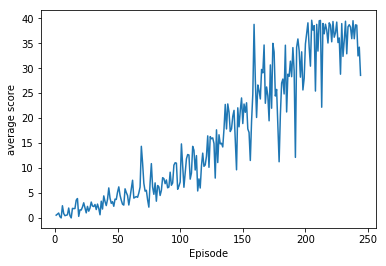

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('average score')
plt.xlabel('Episode')
plt.show()

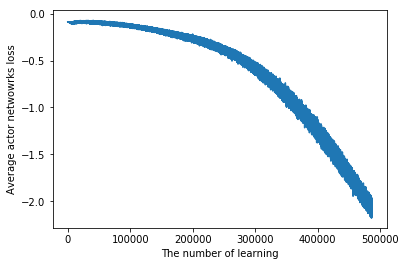

In [32]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(actor_loss)+1, 1), actor_loss)
plt.ylabel('Average actor netwowrks loss')
plt.xlabel('The number of learning')
plt.show()

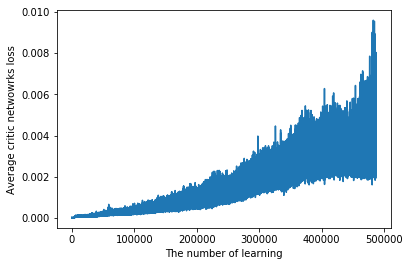

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(critic_loss)+1, 1), critic_loss)
plt.ylabel('Average critic netwowrks loss')
plt.xlabel('The number of learning')
plt.show()

## 3. Watch the Agent

In [28]:
multiAgent = MultiAgent(state_size, action_size, num_agents, params)
multiAgent.load_model(path=target_path)

In [29]:
scores = np.zeros(num_agents)
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
while True:
    actions = multiAgent.act(states)
            
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rewards = env_info.rewards

    multiAgent.step(states, actions, rewards, next_states, dones)
    scores += rewards
    states = next_states
    if np.any(dones):
        break 

In [30]:
episode_score = np.mean(scores)
print('Current Episode Score: {:.4f}'. format(episode_score))

Current Episode Score: 10.9100


In [31]:
env.close()

## 4. Future Works

Even though the current setting can satisfy the project submission requirements, It has several things to be imporved. There are some ideas and I leave these investigations to future work.

1. *More fine-tuning Hyper paramters*

    There might be a better combination of hyperparamters. In general It's not gauranteed to get better results with naively increasing number. Actually I got the worse performance by increasing the training iterations from 15 to 17. So It requires to adjust every other hyperparmeters at the same time. I think soft update ratio($ \tau $) can improve the performance, since the current setting gives slower convergence.
   
    
    
2. *Applying Other Actor-Critic methods*
    
    There are many other actor-critic method such as TRPO(Trust Region Policy Optimization), TNPG(Truncated Natural Policy Gradient) which outperform the DDPG algorithm([Duan et al., Benchmarking Deep Reinforcement Learning for Continuous Control](https://arxiv.org/abs/1604.06778)). The current DDPG algorithm update actor network by using the policy gradient which depends on critic network. So the quality of critic learning procedure might impact the performance of actor network. There have been researches to improve critic learning procedure([Bellemare et al., A Distributional Perspective on Reinforcement Learning](https://arxiv.org/pdf/1707.06887.pdf)). [Barth-Maron et al.](http://arxiv.org/abs/1804.08617) proposed D4PG algorithm with several ideas such as modifying the training procedure and utilizing N-step returns. These works are candidates for the future works.
    
    
3. *Other Normalization Techniques*

    Current model only use batch normalization in actor network. Pytorch has [other normalization layers](https://pytorch.org/docs/stable/nn.html#normalization-layers) like layer norm, instance norm, local reponse norm. These normalization layers might improve the training of networks.